In [29]:
import pandas as pd
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [30]:
df = pd.read_csv('..\data\merged_landmarks.csv')

In [31]:
df.shape

(1099, 746)

## The Data
The dataset we're importing here has 746 columns, but the majority are transformations of the 68 landmarks x and y coordinates.

### The Coordinate Columns:  

***See `derived.md` for full description***

* Original Coordinates 
    * x0, y0, ..., x68, y68
* Normalized Coordinates 
    * norm-x0, norm-y0, ..., norm-x68, norm-y68
* Original Symmetric Deviation 
    * sym_diff-x0, sym_diff-y0, ..., sym_diff-x68, sym_diff-y68
* Yaw-Transformed Coordinates 
    * cenrot-x0, cenrot-y0, ..., cenrot-x68, cenrot-y68
* Normalized and Yaw Transformed Coordinates 
    * norm_cenrot-x0, norm_cenrot-y0, ..., norm_cenrot-x68, norm_cenrot-y68
* Yaw-Transformed Symmetric Deviation 
    * cenrot_sym_diff-x0, cenrot_sym_diff-y0, ..., cenrot_sym_diff-x68, cenrot_sym_diff-y68
* Normalized Yaw-Transformed Symmetric Deviation 
    * norm_cenrot_sym_diff-x0, norm_cenrot_sym_diff-y0, ..., norm_cenrot_sym_diff-x68, norm_cenrot_sym_diff-y68

The remaining columns will be explained where relevant:  

'image_name',
'scale',
'center_w',
'center_h',
'boxratio',
'boxsize',
'width',
'height',
'face_width',
'face_height',
'cenrot_width',
'cenrot_height',
'interoc',
'interoc_norm',
'boxsize/interoc',
'yaw',
'roll',
'baby',
'image-set',
'filename',
'partition',
'subpartition',
'turned',
'occluded',
'expressive',
'tilted'

# EDA  
The paper highlighted two derived features that seem to correlate highly with our desired prediction, in this table:  
![Table II]('..\figs\table2.png')

The left column shows that adults typically have longer faces than babies. The right column shows that babies have a slightly larger interocular distance relative to the size of their face. This is well illustrated in the paper in the figure below:  
![Fig S1]('..\figs\figS1.png')  

Therefore, I'm going to start by exploring just these two parameters.

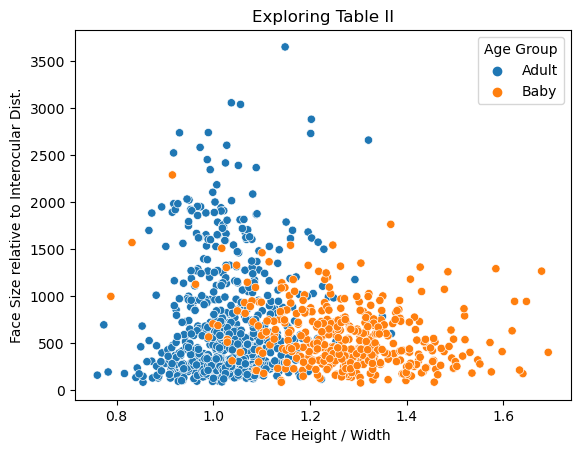

In [32]:
tab2 = df[['boxratio', 'boxsize/interoc','baby']]
ax = sns.scatterplot(data=tab2, x='boxratio', y='boxsize/interoc', hue='baby')
ax.set(
    xlabel='Face Height / Width',
    ylabel='Face Size relative to Interocular Dist.',
    title='Exploring Table II'
)

leg = ax.axes.get_legend()
leg.set_title('Age Group')
legend_labels = ['Adult', 'Baby']
for t, l in zip(leg.texts, legend_labels):
    t.set_text(l)

In [33]:
from matplotlib import colors
cmap = colors.LinearSegmentedColormap(
    "red_blue_classes",
    {
        "red": [(0, 1, 1), (1, 0.7, 0.7)],
        "green": [(0, 0.7, 0.7), (1, 0.7, 0.7)],
        "blue": [(0, 0.7, 0.7), (1, 1, 1)],
    },
)

plt.cm.register_cmap(cmap=cmap)

C:\Users\PC\AppData\Local\Temp\ipykernel_17960\570848556.py:11: UserWarning: Trying to register the cmap 'red_blue_classes' which already exists.
  plt.cm.register_cmap(cmap=cmap)


In [34]:
from sklearn.inspection import DecisionBoundaryDisplay
'''
Plot with Decision boundary
'''

def plot_boundary(clf, X, y, y_pred):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set(
    xlabel='Face Height / Width',
    ylabel='Face Size relative to Interocular Dist.',
    title='LDA Prediction on Table 2 Features'
    )

    tp = y == y_pred  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker=".", color="red", label='True Adult')
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker="x", s=20, color="#990000", label='False Adult')  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker=".", color="blue", label='True Baby')
    plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker="x", s=20, color="#000099", label='False Baby')  # dark blue

    disp = DecisionBoundaryDisplay.from_estimator(
        clf, 
        Xtest, 
        response_method="predict", 
        xlabel='Face Height / Width', 
        ylabel='Face Size relative to Interoc Dist.', 
        alpha=0.5, 
        cmap=cmap, 
        eps=0.5, 
        ax=ax)

    ax.legend(title='LDA Predictions')
    return ax

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df[['boxratio', 'boxsize/interoc']]
y = df[['baby']].squeeze()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.4, random_state=42)

scalar = StandardScaler()
Xtrain = scalar.fit_transform(Xtrain)
Xtest = scalar.transform(Xtest)

(-2.4752750386439306,
 3.6324658971038635,
 -1.6069742787022803,
 6.663609908556998)

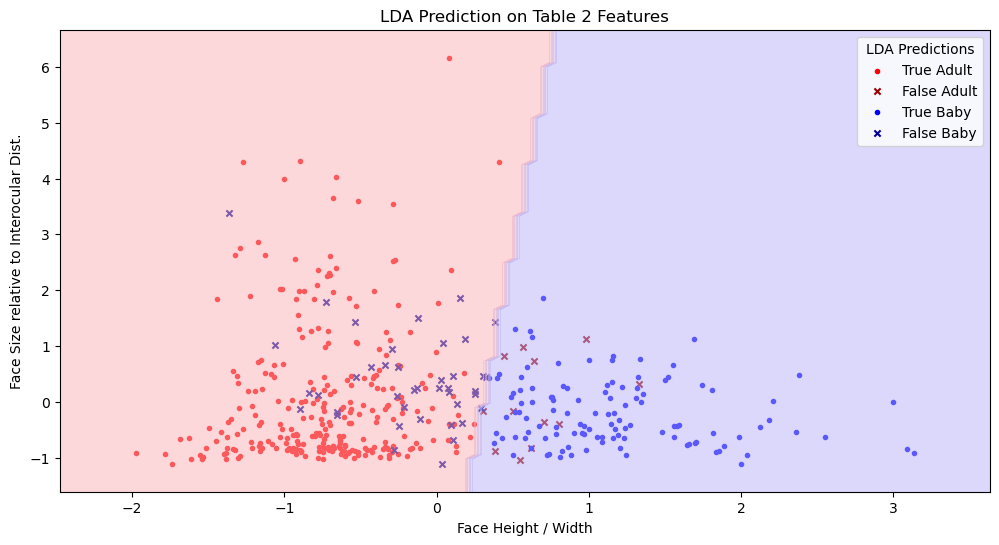

In [36]:
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)

y_pred = lda.fit(Xtrain, ytrain).predict(Xtest)

splot = plot_boundary(lda, Xtest, ytest, y_pred)
plt.axis("tight")

(-2.4752750386439306,
 3.6324658971038635,
 -1.6069742787022803,
 6.663609908556998)

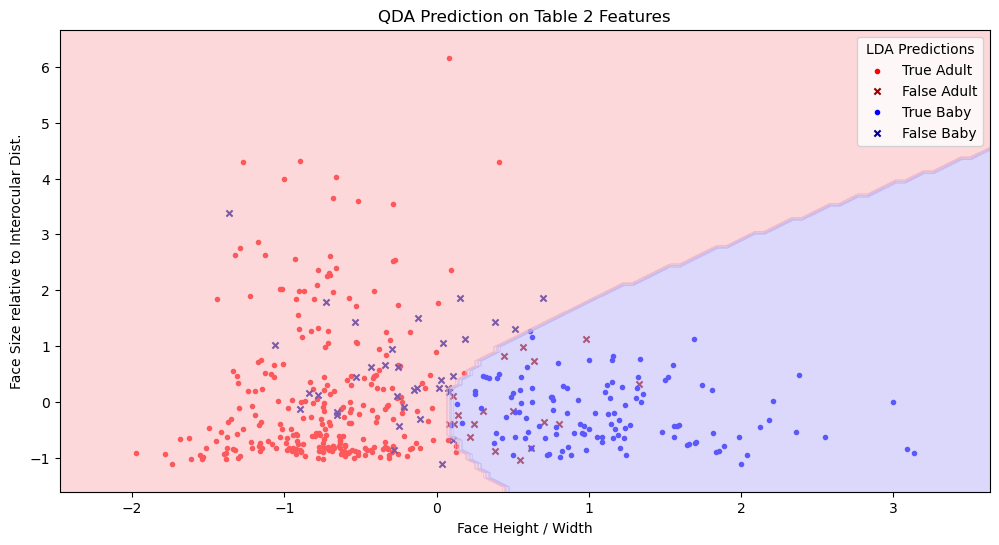

In [37]:
qda = QuadraticDiscriminantAnalysis(store_covariance=True)

y_pred = qda.fit(Xtrain, ytrain).predict(Xtest)

splot = plot_boundary(qda, Xtest, ytest, y_pred)
splot.set_title('QDA Prediction on Table 2 Features')
plt.axis("tight")

In [38]:
import sklearn
print(sklearn.__version__)

1.1.3


(-2.4752750386439306,
 3.6324658971038635,
 -1.6069742787022803,
 6.663609908556998)

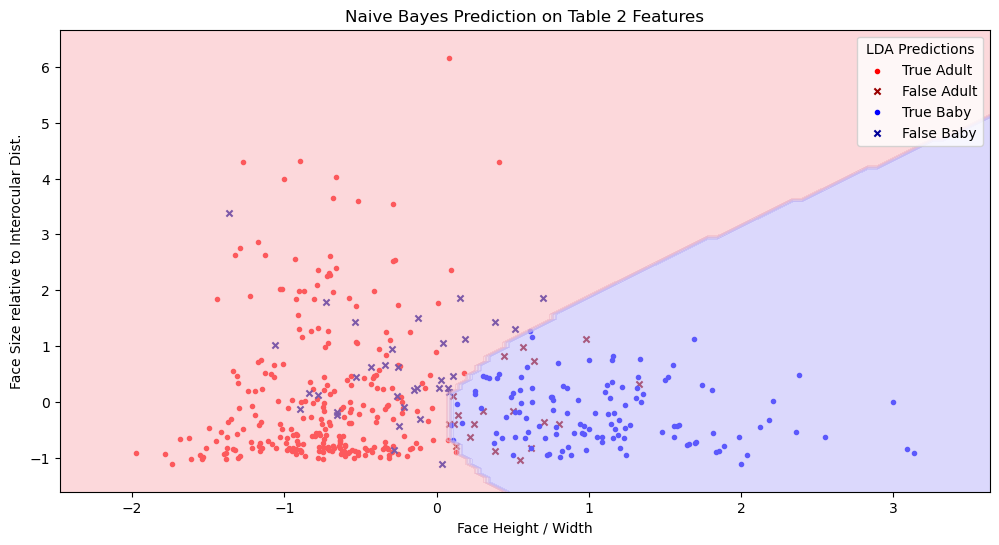

In [39]:
from sklearn.naive_bayes import GaussianNB


nb = GaussianNB()

y_pred = nb.fit(Xtrain, ytrain).predict(Xtest)

ax = plot_boundary(nb, Xtest, ytest, y_pred)
ax.set_title('Naive Bayes Prediction on Table 2 Features')
plt.axis("tight")